In [545]:
import itertools
import plotly.express as px
import chart_studio.plotly as py
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import dgl
from dgl.nn.pytorch import GraphConv

In [546]:
percentage_labeled = 0.05
num_labels = int(percentage_labeled * 48)

coordinates = pd.read_csv("./StateLatLong_USA.csv")
population_density = pd.read_csv('./DensPob_USA.csv')
ground_truth_labels = pd.read_csv('./StatesGroundTruth_USA.csv')
states_list = coordinates["State"].to_list()
lat_list = coordinates["Lat"]
lon_list = coordinates['Long']

In [547]:
population_density = population_density.sort_values(by=['Density'])
fig = px.bar(population_density, y="State", x="Density", orientation='h',height=900,width=900,labels={'Density':'Population Density [inhabitants per square mi]','State':'State'})
fig.show()

In [548]:
G=dgl.DGLGraph()

In [549]:
G.add_nodes(48)

In [550]:
def build_map():
  src=np.array([0 ,0 ,0 ,0 ,
                1 ,1 ,1 ,1 ,
                2 ,2 ,2 ,2 ,2 ,2 ,
                3 ,3 ,3 ,
                4 ,4 ,4 ,4 ,4 ,4 ,
                5 ,5 ,5 ,
                6 ,6 ,6 ,
                7 ,7 , 
                8 ,8 ,8 ,8 ,8 , 
                9 ,9 ,9 ,9 ,9 ,9 , 
                10 ,10 ,10 ,10 ,10 ,
                11 ,11 ,11 ,11 ,
                12 ,12 ,12 ,12 ,12 ,12 ,
                13 ,13 ,13 ,13 ,
                14  ,14 ,14 ,14 ,14 ,14 ,14 ,
                15 , 15 ,15 ,
                16 ,
                17 ,17 ,17 ,17 , 
                18 ,18 ,18 ,18 , 18 ,
                19 ,19 ,19 ,
                20 ,20 ,20 ,20 ,
                21 ,21 ,21 ,21 ,
                22 ,22 ,22 ,22 ,22 ,22 ,22 ,22 ,
                23 ,23 ,23 ,23 ,
                24 ,24 ,24 ,24 ,24 ,24 ,
                25 ,25 ,25 ,25 ,25 ,
                26 ,26 ,26 ,
                27 ,27 ,27 ,
                28 ,28 ,28 ,28 ,28 ,
                29 ,29 ,29 ,29 ,29 ,
                30 ,30 ,30 ,30 ,
                31 ,31 ,31 ,
                32 ,32 ,32 ,32 ,32 ,
                33 ,33 ,33 ,33 ,33 ,33 ,
                34 ,34 ,34 ,34 ,
                35 ,35 ,35 ,35 ,35 ,35 ,
                36 ,36 ,
                37 ,37 ,
                38 ,38 ,38 ,38 ,38 ,38 ,
                39 ,39 ,39 ,39 ,39 ,39 ,39 ,39 ,
                40 ,40 ,40 ,40 ,
                41 ,41 ,41 ,41 ,41 ,41 ,
                42 ,42 ,42 ,
                43 ,43 ,43 ,43 ,43 ,
                44 ,44 ,
                45 ,45 ,45 ,45 ,45 ,
                46 ,46 ,46 ,46 ,
                47 ,47 ,47 ,47 ,47 ,47])
  dst=np.array([ 21, 39, 7, 8,
       3, 25, 41, 28,
       15, 40, 33, 22, 39, 21,
       34, 25, 1,
       28, 41, 47, 24, 13, 33,
       29, 18, 36,
       17, 25, 27,
       0, 8,
       0, 7, 39, 37, 30, 
       25, 24, 44, 23, 47, 41,
       22, 12, 46, 11, 14,
       14, 10, 19, 32,
       24, 38, 20, 46, 10, 22,
       4, 24, 22, 33,
       22, 10, 11, 32, 45, 43, 39,
       40, 2, 21,
       26,
       45, 43, 35, 6,
       29, 42, 26, 5, 36,
       11, 32, 46,
       31, 38, 12, 46,
       15, 2, 39, 0,
       33, 13, 24, 12, 10, 14, 39, 2,
       9, 47, 31, 38,
       4, 47, 38, 12, 22, 13,
       1, 3, 34, 9, 41,
       16, 42, 18,
       6, 35, 29,
       1, 41, 4, 33, 40,
       35, 27, 42, 18, 5,
       23, 38, 20,
       19, 11, 14, 45, 35,
       40, 28, 4, 13, 22, 2,
       44, 9, 25, 3,
       32, 45, 17, 27, 29,
       5, 18,
       8, 30,
       47, 23, 31, 20, 12, 24,
       21, 2, 22, 14, 43, 30, 8, 0,
       28, 33, 2, 15,
       28, 1, 25, 9, 47, 4,
       26, 29, 18,
       45, 17, 14, 39, 30,
       9, 34,
       32,  35, 17, 43, 14,
       20, 12, 10, 19,
       9, 23, 38, 24, 41, 4])
  u=np.concatenate([src,dst])
  v=np.concatenate([dst,src])
  return dgl.DGLGraph((u,v))

In [551]:
G=build_map()

In [552]:
print(G.number_of_nodes())
print(G.number_of_edges())

48
419


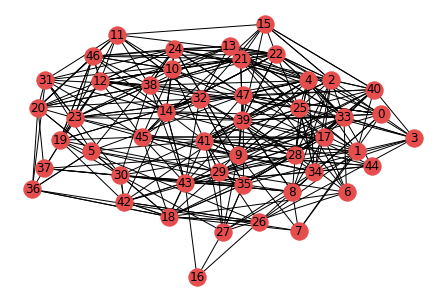

In [553]:
nx_G = G.to_networkx().to_undirected()
pos = nx.kamada_kawai_layout(nx_G)

nx.draw(nx_G, pos, with_labels=True, node_color=[[.9, .3, .3]])

In [554]:
embed = nn.Embedding(48, 48)  

In [555]:
x = torch.arange(0,48)
G.ndata['feat'] =torch.nn.functional.one_hot(x)

In [566]:
for i in range(48):
  G.ndata['feat'][i]=G.ndata['feat'][i]*population_density['Density'][i]


print(G.ndata['feat'][47])

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 36])


In [557]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        return h


net = GCN(48, 10, 5)

In [558]:
inputs = embed.weight
#labeled_nodes = torch.tensor([3,17,13,18,4,1])  
#labels = torch.tensor([0,0,1,1,2,2])

sample = ground_truth_labels.sample(n = num_labels)

training_labeled_nodes = torch.tensor(sample.index.to_numpy())
training_labels = torch.tensor(sample['Label'].to_numpy())

total_labeled_nodes = ground_truth_labels.index.to_numpy()
total_labels = ground_truth_labels['Label'].to_numpy()

In [559]:
optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters()), lr=0.01)
all_logits = []
for epoch in range(500):
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[training_labeled_nodes], training_labels)
    
    _, predicted = torch.max(logp.data, 1)
    
    correct_predictions = (predicted == torch.tensor(total_labels)).sum().item()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f | Accuracy: %.4f' % (epoch, loss.item(), correct_predictions/48*100))

Epoch 0 | Loss: 1.7960 | Accuracy: 25.0000
Epoch 1 | Loss: 1.6077 | Accuracy: 25.0000
Epoch 2 | Loss: 1.4595 | Accuracy: 25.0000
Epoch 3 | Loss: 1.3370 | Accuracy: 29.1667
Epoch 4 | Loss: 1.2329 | Accuracy: 29.1667
Epoch 5 | Loss: 1.1405 | Accuracy: 20.8333
Epoch 6 | Loss: 1.0552 | Accuracy: 25.0000
Epoch 7 | Loss: 0.9717 | Accuracy: 22.9167
Epoch 8 | Loss: 0.8912 | Accuracy: 25.0000
Epoch 9 | Loss: 0.8105 | Accuracy: 27.0833
Epoch 10 | Loss: 0.7292 | Accuracy: 27.0833
Epoch 11 | Loss: 0.6491 | Accuracy: 27.0833
Epoch 12 | Loss: 0.5707 | Accuracy: 27.0833
Epoch 13 | Loss: 0.4950 | Accuracy: 27.0833
Epoch 14 | Loss: 0.4221 | Accuracy: 27.0833
Epoch 15 | Loss: 0.3537 | Accuracy: 27.0833
Epoch 16 | Loss: 0.2902 | Accuracy: 25.0000
Epoch 17 | Loss: 0.2333 | Accuracy: 25.0000
Epoch 18 | Loss: 0.1840 | Accuracy: 25.0000
Epoch 19 | Loss: 0.1419 | Accuracy: 25.0000
Epoch 20 | Loss: 0.1075 | Accuracy: 22.9167
Epoch 21 | Loss: 0.0805 | Accuracy: 22.9167
Epoch 22 | Loss: 0.0599 | Accuracy: 20.833

Epoch 185 | Loss: 0.0002 | Accuracy: 22.9167
Epoch 186 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 187 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 188 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 189 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 190 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 191 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 192 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 193 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 194 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 195 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 196 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 197 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 198 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 199 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 200 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 201 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 202 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 203 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 204 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 205 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 206 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 207 

Epoch 375 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 376 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 377 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 378 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 379 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 380 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 381 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 382 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 383 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 384 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 385 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 386 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 387 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 388 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 389 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 390 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 391 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 392 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 393 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 394 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 395 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 396 | Loss: 0.0001 | Accuracy: 22.9167
Epoch 397 

In [560]:
df=pd.DataFrame(all_logits[249][:].numpy())

In [561]:
lista=[]
for i in range(48):
  lista.append((all_logits[249][i].numpy().argmax()))



df['li']=pd.Series(lista)

In [562]:
df['Lat'] = lat_list
df['Long'] = lon_list
df['State'] = states_list

In [563]:
df

,0,1,2,3,4,li,Lat,Long,State
0,2.265916,-5.177767,-4.883596,-1.266901,-5.082537,0,32.601011,-86.680736,Alabama
1,-0.149968,-5.441932,-4.892444,2.286881,-6.125270,3,34.168219,-111.930907,Arizona
2,0.007003,-6.477802,-5.675048,2.922644,-7.100718,3,34.751928,-92.131378,Arkansas
3,-1.310345,-4.110790,-3.750885,3.643226,-4.958230,3,37.271875,-119.270415,California
4,-0.037578,-5.858948,-5.216472,2.638600,-6.217881,3,38.997934,-105.550567,Colorado
5,-0.430995,-3.444651,-3.230521,1.673456,-4.156468,3,41.518784,-72.757507,Connecticut
6,-1.188385,-4.113258,-3.681911,3.322041,-4.940786,3,39.145251,-75.418921,Delaware
7,1.928060,-3.686038,-3.327852,-1.762838,-3.868470,0,27.975728,-83.833017,Florida
8,0.635200,-5.384866,-5.320467,0.996640,-6.001944,3,32.678125,-83.222976,Georgia
9,1.773994,-6.746313,-6.186569,0.088545,-6.806177,0,45.494576,-114.142430,Idaho


In [564]:
fig = px.scatter_geo(df, lat="Lat",lon="Long", color='li',size=df['li']+1,
                     #animation_frame="Fecha",
                     scope='north america',#range_color=[0,max(todos['conteo'])],
                     center={'lat':19,'lon':-99},width=800,text = df['State'],
                     projection="natural earth")


fig.show()

In [565]:
output = {'State': states_list, 'Prediction': lista}
output = pd.DataFrame(data=output)
output.to_csv('predicted_'+str(percentage_labeled*100)+'_labeled.csv', index = False)